## Pre processamento da serie temporal 01 - cotacao do dolar
### Transformacao da serie para estacionaria

In [59]:
import pandas as pd
import numpy as np
import warnings

# imports de modulos que estao definidos dentro do projeto
import data
import timeseries
import arima

import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
df_daily = data.load_timeseries01_daily()
#timeseries.plot_timeserie(df_daily)

In [61]:
df_monthly = data.load_timeseries01_monthly()
#timeseries.plot_timeserie(df_monthly)

### Transformacao da serie temporal DIARIA

In [62]:
log_df_daily = np.log(df_daily)
#timeseries.plot_timeserie(log_df_daily)

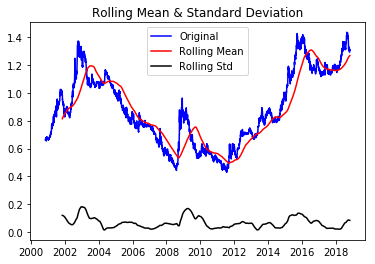

Results of Dickey-Fuller Test:
Test Statistic (-1.128302) > Critical Value 1 (-3.431348)
Test Statistic (-1.128302) > Critical Value 5 (-2.861981)
Test Statistic (-1.128302) > Critical Value 10 (-2.567005)
p-value (0.703655) > 0.05


In [63]:
timeseries.check_stationarity(log_df_daily, window=365)

In [64]:
log_df_daily_diff = log_df_daily - log_df_daily.shift()
log_df_daily_diff.dropna(inplace=True)
#timeseries.plot_timeserie(log_df_daily_diff)

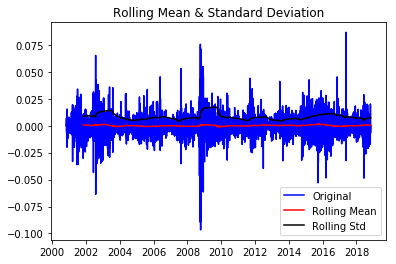

Results of Dickey-Fuller Test:
Test Statistic (-15.399245) < Critical Value 1 (-3.431348)
Test Statistic (-15.399245) < Critical Value 5 (-2.861981)
Test Statistic (-15.399245) < Critical Value 10 (-2.567005)
p-value (0.000000) < 0.05


In [65]:
timeseries.check_stationarity(log_df_daily_diff, window=365)

### Transformacao da serie temporal MENSAL

In [66]:
log_df_monthly = np.log(df_monthly)
#timeseries.plot_timeserie(log_df_monthly)

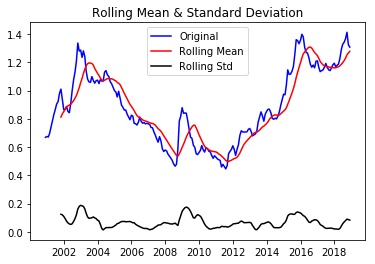

Results of Dickey-Fuller Test:
Test Statistic (-1.431590) > Critical Value 1 (-3.461136)
Test Statistic (-1.431590) > Critical Value 5 (-2.875079)
Test Statistic (-1.431590) > Critical Value 10 (-2.573986)
p-value (0.567042) > 0.05


In [67]:
timeseries.check_stationarity(log_df_monthly, window=12)

In [68]:
log_df_monthly_diff = log_df_monthly - log_df_monthly.shift()
log_df_monthly_diff.dropna(inplace=True)
#timeseries.plot_timeserie(log_df_monthly_diff)

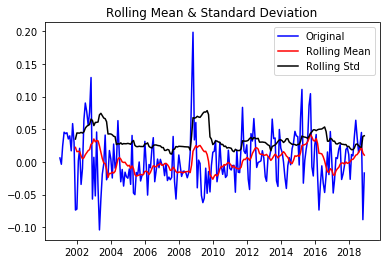

Results of Dickey-Fuller Test:
Test Statistic (-9.652797) < Critical Value 1 (-3.461136)
Test Statistic (-9.652797) < Critical Value 5 (-2.875079)
Test Statistic (-9.652797) < Critical Value 10 (-2.573986)
p-value (0.000000) < 0.05


In [69]:
timeseries.check_stationarity(log_df_monthly_diff, window=12)

### Grid Search para o ARIMA aplicado na serie temporal DIARIA

### Grid Search para o ARIMA aplicado na serie temporal MENSAL

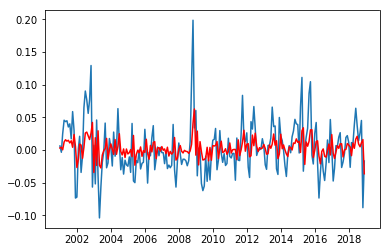

In [70]:
from statsmodels.tsa.arima_model import ARIMA

# ARIMA model
model = ARIMA(log_df_monthly, order=(0, 1, 1))
results_ARIMA = model.fit(disp=-1) # -1, 0

plt.plot(log_df_monthly_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')

Text(0.5,1,'RMSE: 0.5429')

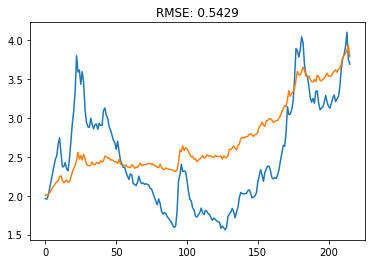

In [71]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
#print(predictions_ARIMA_diff.head())

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
#print(predictions_ARIMA_diff_cumsum.head())

predictions_ARIMA_log = pd.Series(log_df_monthly.iloc[0], index=log_df_monthly.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
#print(predictions_ARIMA_log.head())

predictions_ARIMA = np.exp(predictions_ARIMA_log)
#arima.print_dataframe_info(predictions_ARIMA)
predictions_ARIMA = predictions_ARIMA.apply(lambda x: x*2) # gambiarra ...

rates = []
for row_index, row in df_monthly.iterrows():
    rates.append(row[0])

t = pd.Series(data=rates, index=df_monthly.index, copy=True)
#arima.print_dataframe_info(t)

plt.plot(t[1:].values)
plt.plot(predictions_ARIMA[1:].values)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA[1:] - t[1:])**2)/len(t[1:])))

Text(0.5,1,'MSE: 0.294737')

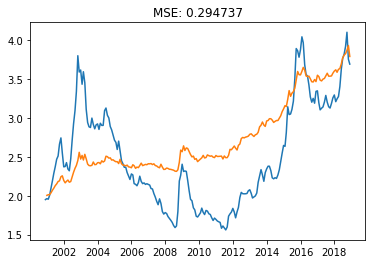

In [72]:
from sklearn.metrics import mean_squared_error

plt.plot(t.index.to_pydatetime(), t.values)
plt.plot(t.index.to_pydatetime(), predictions_ARIMA.values)
#plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA[1:] - t[1:])**2)/len(t[1:])))
plt.title('MSE: %.6f'% mean_squared_error(t[1:].values, predictions_ARIMA[1:].values))

In [73]:
arima_params = arima.get_arima_params(
    p_values=range(0, 3),
    d_values=range(0, 2),
    q_values=range(0, 2))
#print(arima_params)

warnings.filterwarnings("ignore")
arima.evaluate_models(log_df_monthly.values, arima_params)

Parameter 'dataset' length:  217
Variable 'train_size' value:  143
Dataset 'train' length:  143
Dataset 'test' length:  74
ARIMA(0, 0, 0) MSE=0.100770859
ARIMA(0, 0, 1) MSE=0.028136190
ARIMA(0, 1, 0) MSE=0.001366716
ARIMA(0, 1, 1) MSE=0.001153267
ARIMA(1, 0, 0) MSE=0.001437790
ARIMA(1, 0, 1) MSE=0.001209381
ARIMA(1, 1, 0) MSE=0.001201088
ARIMA(1, 1, 1) MSE=0.001200744
ARIMA(2, 0, 0) MSE=0.001252497
ARIMA(2, 0, 1) MSE=0.001261867
ARIMA(2, 1, 0) MSE=0.001201705
Best ARIMA(0, 1, 1) MSE=0.001153267
